## Feature Selection and Dimensionality Reduction Demonstrations
### scRNA-seq analysis in Python course 2024, EBI

#### Preparation

In [1]:
# Package dependencies and suppress unnecessary warning messages 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

import os
prefix_output = "../Data/results/03" # for notebook 03
os.mkdirs(prefix_output, exist_ok=True)

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
# Read data
# Contains counts for 500 cells per sample
adata = sc.read_h5ad("../Data/Caron_normalized.500.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 5500 × 29346
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor'
    var: 'ID', 'Symbol', 'Chromosome'


In [5]:
adata.obs

,Sample,Barcode,SampleName,SampleGroup,sum,detected,subsets_Mito_sum,subsets_Mito_detected,subsets_Mito_percent,total,sizeFactor
1_CGACTTCGTCCAGTTA-1,SRR9264343,1_CGACTTCGTCCAGTTA-1,ETV6-RUNX1_1,ETV6-RUNX1,4557.0,2024,119.0,12,2.611367,4557.0,0.824416
1_AGAATAGCATACGCTA-1,SRR9264343,1_AGAATAGCATACGCTA-1,ETV6-RUNX1_1,ETV6-RUNX1,7745.0,2695,411.0,12,5.306649,7745.0,1.346255
1_TGACTAGAGAACTCGG-1,SRR9264343,1_TGACTAGAGAACTCGG-1,ETV6-RUNX1_1,ETV6-RUNX1,7181.0,2617,382.0,11,5.319593,7181.0,1.193597
1_CTTAACTGTTATGCGT-1,SRR9264343,1_CTTAACTGTTATGCGT-1,ETV6-RUNX1_1,ETV6-RUNX1,1704.0,1081,129.0,9,7.570423,1704.0,0.436306
1_CCCAGTTTCAAGCCTA-1,SRR9264343,1_CCCAGTTTCAAGCCTA-1,ETV6-RUNX1_1,ETV6-RUNX1,6914.0,2570,371.0,12,5.365924,6914.0,1.231494
...,...,...,...,...,...,...,...,...,...,...,...
8_CTCTACGTCTGCCAGG-1,SRR9264350,8_CTCTACGTCTGCCAGG-1,PRE-T_2,PRE-T,4324.0,1975,96.0,10,2.220167,4324.0,0.787487
8_CGAATGTCAAGCCATT-1,SRR9264350,8_CGAATGTCAAGCCATT-1,PRE-T_2,PRE-T,2426.0,1246,16.0,7,0.659522,2426.0,0.439418
8_TAAGCGTCATCGGAAG-1,SRR9264350,8_TAAGCGTCATCGGAAG-1,PRE-T_2,PRE-T,5454.0,2299,93.0,11,1.705171,5454.0,1.073091
8_AGCGTCGAGATGTAAC-1,SRR9264350,8_AGCGTCGAGATGTAAC-1,PRE-T_2,PRE-T,4221.0,1926,75.0,12,1.776830,4221.0,0.819905


In [6]:
# Since this object is converted from an SCE object, we first need to check what is in the adata.X matrix
# We can see that different cells have different total counts. This means that the matrix in adata.X is not yet size-factor normalised.
# Perhaps the conversion method we used did not pick up the normalized data slot and just kept the raw data, but thats easily solvable
adata.X.sum(axis=1)

matrix([[ 4557.],
        [ 7745.],
        [ 7181.],
        ...,
        [ 5454.],
        [ 4221.],
        [10878.]])

In [7]:
# They are also clearly not log1p normalized given the value range
adata.X.max()

8900.0

In [8]:
# Use gene symbols as index - making sure they are unique
adata.var_names_make_unique()

#### Gene variance & HVGs

In [9]:
# Make sure data is normalised, and log1p transformed before identifying highly variable genes
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)

In [10]:
# Select highly variable genes by normalized variance (seurat flavor is the default, which expects log1p normalized data)
# The Seurat flavor is dispersion-based: the normalized dispersion is obtained by scaling with the mean and standard deviation of the dispersions for genes falling into a given bin for mean expression of genes. 
# This means that for each bin of mean expression, highly variable genes are selected.
# There are many other methods to select HVGs, for instance, the Seurat_v3 flavor, which expects count data instead
# See more in scanpy API: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html#scanpy.pp.highly_variable_genes

sc.pp.highly_variable_genes(adata, n_top_genes=int(0.1 * adata.n_vars), flavor="seurat")

<Figure size 1000x600 with 0 Axes>

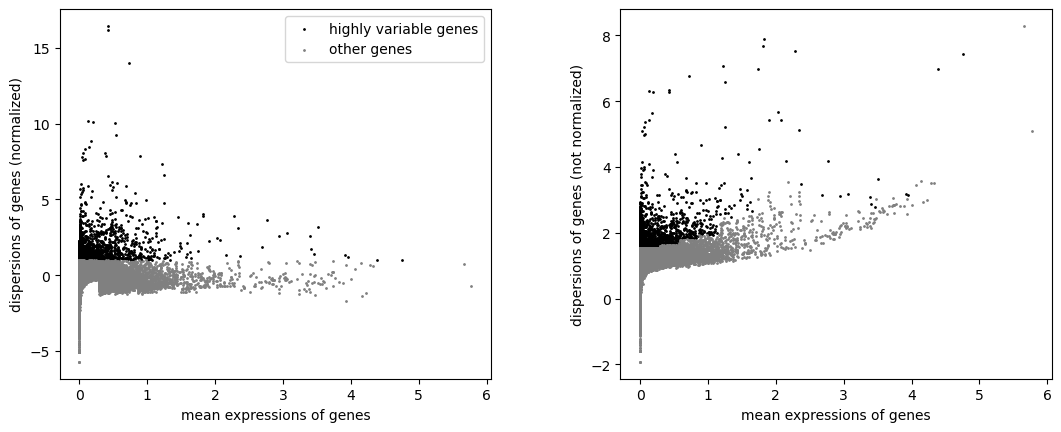

In [11]:
# Plot the mean and dispersion of HVGs
# The thing to check that normalisation is effective, by making sure that not all HVGs are highly expressed but they are roughly drawn from different expression levels, while having a high dispersion
plt.figure(figsize=(10, 6))
sc.pl.highly_variable_genes(adata)

In [12]:
# Get the most highly variable genes (HVGs)
hvgs = adata.var.index[adata.var.highly_variable]
print(f"Number of HVGs: {len(hvgs)}")
print(f"First 10 HVGs: {hvgs[:10].tolist()}")

Number of HVGs: 2934
First 10 HVGs: ['ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000184163', 'ENSG00000205116', 'ENSG00000157933', 'ENSG00000284668', 'ENSG00000187017', 'ENSG00000173662', 'ENSG00000236266']


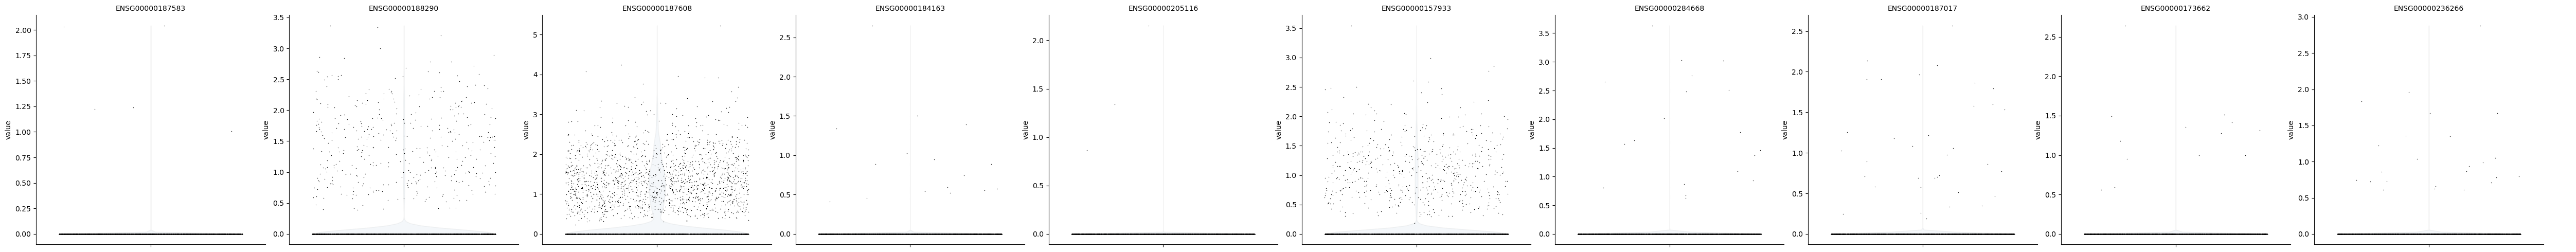

In [13]:
# Visualise their expression
# Notice that these genes have a much higher expression in some of the cells, but not in the majority others
sc.pl.violin(adata, hvgs[:10], jitter=0.4, alpha=0.05, multi_panel=True)

#### Dimensionality reduction by PCA

In [14]:
# Run PCA, we calculate 100 PC components here to "over-compute" for demonstration pourposes, while the default is 50
sc.tl.pca(adata, use_highly_variable=True, n_comps=100)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [15]:
# Extract a few rows and columns of the PCA matrix
print(adata.obsm["X_pca"][:10, :5])

[[-5.362955    0.18813787 -2.773573   -4.390448   -0.8924715 ]
 [-3.968803   -0.6463945  -3.4247575  -4.3787613  -1.4656365 ]
 [-4.286394   -0.51757914 -2.9981544  -3.5896926  -1.0586424 ]
 [-4.1664867  -0.704671   -4.0504675  -3.2729874  -0.6333079 ]
 [-6.4048247  -0.612379   -3.5450537  -4.0627112  -0.9486673 ]
 [-4.521558   -0.44014442 -3.5235689  -3.3562112  -0.17945571]
 [-6.020457   -1.0617063  -4.398025   -2.5053065  -1.2636946 ]
 [-6.318881   -0.03455273 -3.1736147  -4.097885   -0.89889383]
 [-5.855236   -0.411851   -2.9522772  -4.585679   -1.6074558 ]
 [-4.768254   -0.6716693  -1.9955224  -3.0142596  -1.0460098 ]]


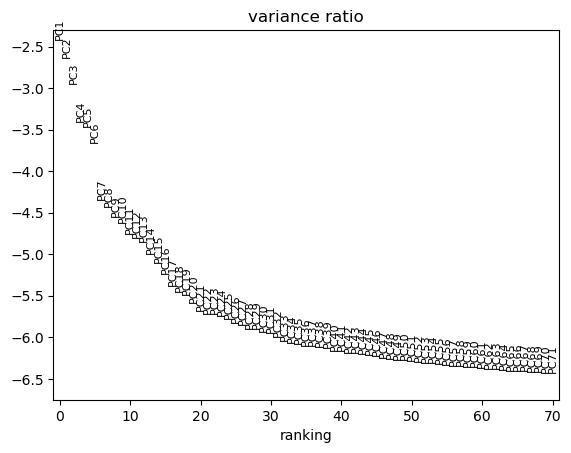

In [16]:
# Visualise the percent variance explained by each PC
# This is called a PCA scree plot, we can see that it reaches a plateau at around 50 or 60 PCs
sc.pl.pca_variance_ratio(adata, n_pcs=70, log=True)

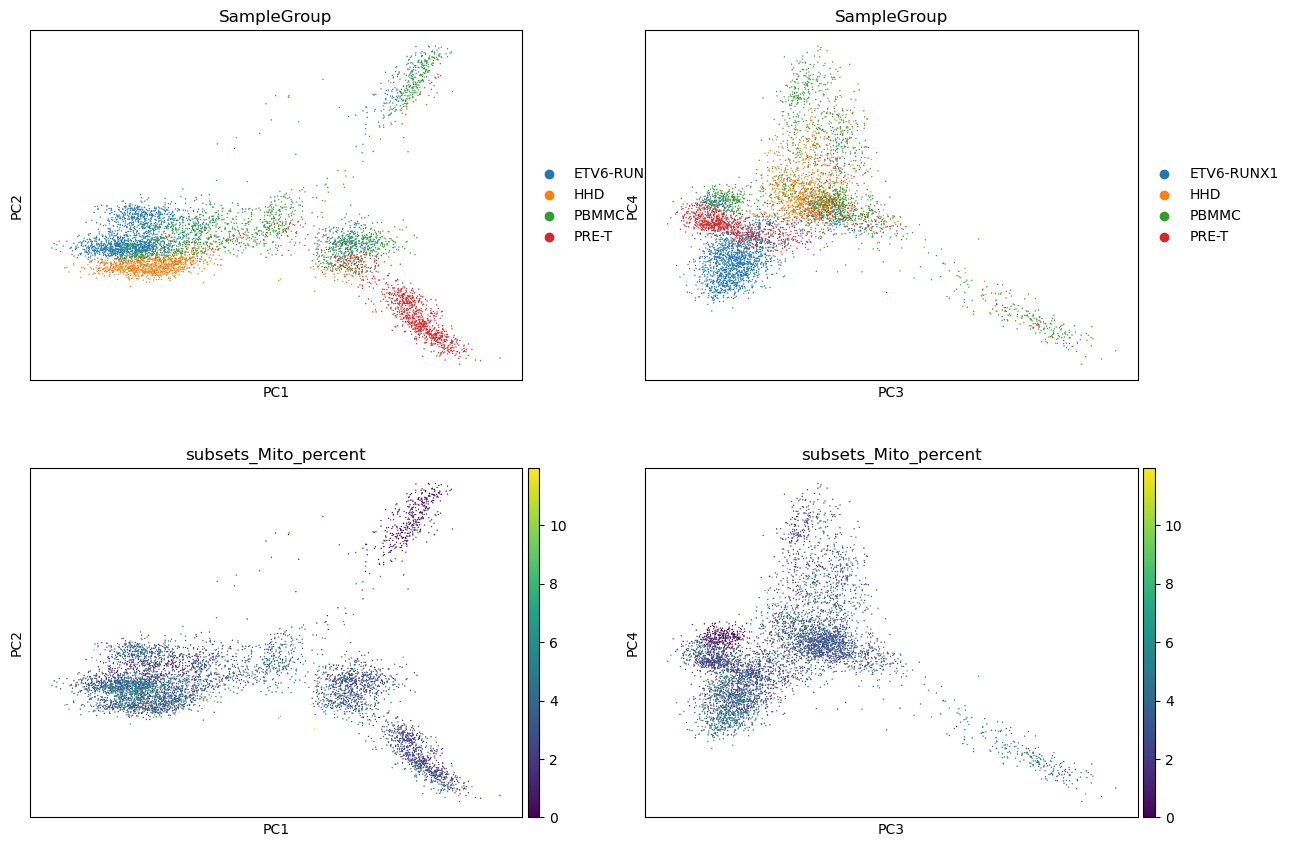

In [17]:
# Visualise PCA result - PC1 vs PC2, PC3 vs PC4
# Check for batch labels and QC metrics, whether any of them drive significant variation in the dataset
sc.pl.pca(
    adata,
    color=["SampleGroup", "SampleGroup", "subsets_Mito_percent", "subsets_Mito_percent"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=4,
)

# We can see that different SampleGroup showed significant variation on the PC space, butb pct_mito didn't

#### Visualisation by UMAP

UMAP is a non-linear method of dimensionality reduction. It is most useful because it projects the data to 2D, allowing us humans to visualize it easily. 

It claims to have better preservation of global distance than the previously-used tSNE, but there has been debates about whether this property is as good as it seems.

The results of a UMAP projection should be used for visualisation only and not for downstream analysis (such as cell clustering).

In [18]:
# First, we need to compute the neighbour graph of cells based on their PCs
# Choose n_pcs based on the scree plot
# Using more PCs will include more information, if the cellular composituon of your data is complex, but keep in mind that later PCs are more likely to just represent noise in the data
sc.pp.neighbors(adata, n_pcs=50)

2024-09-20 14:02:33.448066: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 14:02:33.478579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Now, we visualize the neighbour graph by calculating UMAP (McInnes et al., 2018):
# It projects the graph into 2D

sc.tl.umap(adata)

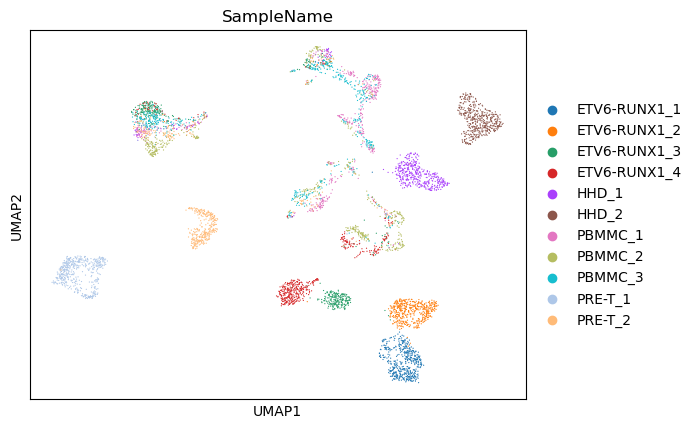

In [20]:
sc.pl.umap(
    adata,
    color="SampleName", # Colour by sample name
    # Setting a smaller point size to get prevent overlap
    size=3,
)

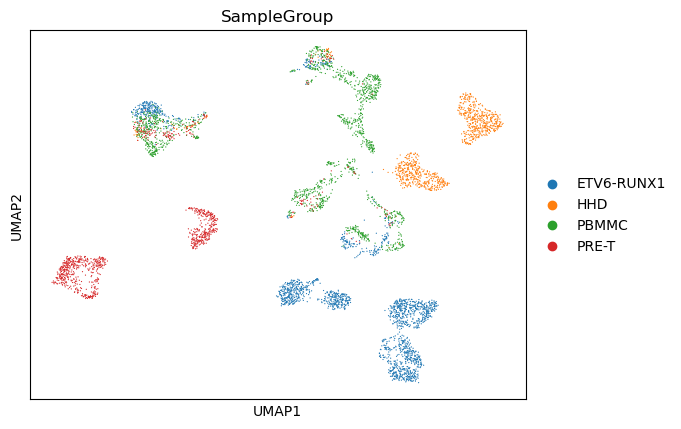

In [21]:
sc.pl.umap(
    adata,
    color="SampleGroup", # Colour by sample type
    # Setting a smaller point size to get prevent overlap
    size=3,
)

#### We can see that the different samples have quite a large batch effect
#### So lets proceed to batch correction and data integration

In [ ]:
# save processed adata

adata.write_h5ad(f'{prefix_output}/03_dim_reduced_Caron_normalized.500.h5ad')

---
### Exercises

**Question 1:** Generate UMAP using n_neighbors = 5, n_neighbors = 50, and n_neighbors = 500, observe the differences

**Question 2:** If the Eucledian distance between the centroid of cluster A with cluster B is smaller than that with cluster C on the UMAP, does it mean that cells in cluster A are transcriptomically more similar with cells in cluster B, than cluster C?